In [1]:
# import libraries
import pandas as pd
import numpy as np
import pm4py
import editdistance
from label_functions import *

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


In [2]:
# import data
def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
    return event_log

event_log = import_xes("data/Hospital_log.xes.gz")

parsing log, completed traces ::   0%|          | 0/1143 [00:00<?, ?it/s]

Start activities: {'1e consult poliklinisch': 71, 'inwend.geneesk.  korte kaart kosten-out': 8, 'verlosk.-gynaec. korte kaart kosten-out': 198, 'vervolgconsult poliklinisch': 234, 'verlosk.-gynaec.   jaarkaart kosten-out': 122, 'cytologisch onderzoek - ectocervix -': 28, 'echografie  - genitalia interna': 44, 'aanname laboratoriumonderzoek': 225, 'ligdagen - alle spec.beh.kinderg.-reval.': 39, 'telefonisch consult': 15, 'behandeltijd - eenheid t3 - megavolt': 1, 'ct abdomen': 2, 'behandeltijd - eenheid t2 - megavolt': 1, 'thorax': 12, 'e.c.g.      - elektrocardiografie': 63, 'cytologisch onderzoek - vagina -': 12, 'mammografie thoraxwand': 3, 'histologisch onderzoek - biopten nno': 19, 'dagverpleging - alle spec.beh.kind.-rev.': 5, 'inwend.geneesk.    jaarkaart kosten-out': 1, 'coupe ter inzage': 19, 'immunopathologisch onderzoek': 10, 'vagina      - scopie incl.evt.vulvabiops': 3, 'punctie tbv cytologisch onderzoek door p': 3, 'cytologisch onderzoek - buiktumorpunctie': 1, 'vrw.gesl.o

In [3]:
# convert all activity codes to strings
event_log['Activity code'] = event_log['Activity code'].astype(str)

# get all traces
all_traces = event_log.groupby('case:concept:name')['Activity code'].apply(list)

In [4]:
def get_similarity(running_trace, traces, similarity=True):
    '''
    Calculate edit distances between running trace and all traces in the log.
    Convert to similarity score if similarity=True.
    '''
    # convert running trace to list if it is a series
    if isinstance(running_trace, pd.Series):
        running_trace = running_trace.iloc[0]
    
    # calculate edit distances
    str_edit_dist = []
    for case, activities in traces.items():
        distance = editdistance.eval(running_trace, activities)
        if similarity:
            similarity_score = 1 - distance / max(len(running_trace), len(activities))
            str_edit_dist.append((case, similarity_score))
        else:
            str_edit_dist.append((case, distance))
    return dict(str_edit_dist)

In [110]:
def train_model(X_cols, event_log, similar_traces_list, lf_map):
    # Get last event for each trace in similar_traces_list (training set)
    X_train = event_log.groupby('case:concept:name')[X_cols].last().loc[similar_traces_list]

    # Fill missing values and convert to string
    X_train = X_train.fillna('Missing', axis=1)
    for col in X_cols:
        X_train[col] = X_train[col].astype(str)

    # Convert to categorical (use a dictionary of LabelEncoders for each column)
    le_dict = {col: LabelEncoder() for col in X_cols}

    # Fit each encoder on the training data and transform the training data
    for col in X_cols:
        X_train[col] = le_dict[col].fit_transform(X_train[col])

    # Convert X and y to arrays
    X_train = X_train.to_numpy()
    y_train = np.array([lf_map[trace] for trace in similar_traces_list]).astype(int)

    # Train decision tree model
    clf = DecisionTreeClassifier(max_depth=3, random_state=0)
    clf.fit(X_train, y_train)

    return clf, le_dict

def predict_label(X_cols, event_log, running_trace, clf, le_dict):
    # Prepare the test data (running_trace)
    X_test = event_log.groupby('case:concept:name')[X_cols].last().loc[running_trace.index]

    # Fill missing values and convert to string
    X_test = X_test.fillna('Missing', axis=1)
    for col in X_cols:
        X_test[col] = X_test[col].astype(str)

    # Use the same label encoders to transform the test data
    for col in X_cols:
        try:
            X_test[col] = le_dict[col].transform(X_test[col])
        except:
            # if the value is not in the training data, use 'Missing'
            X_test[col] = le_dict[col].transform(['Missing'])[0]

    # Convert X_test to a numpy array
    X_test = X_test.to_numpy()

    # Predict label for the running trace
    y_pred = int(clf.predict(X_test))

    return y_pred


In [112]:
df_predictions = []
for i in range(len(all_traces)):
    if i % 100 == 0:
        print(f'Processing trace {i}/{len(all_traces)}')
    
    running_trace = all_traces.iloc[[i]]
    historic_traces = all_traces.drop(running_trace.index)

    # TODO: prefix extraction of historic traces?

    # calculate similarity scores
    similarity_scores = get_similarity(running_trace, historic_traces, similarity=True)

    # get n most similar traces
    n = 100
    sorted_similar_traces = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    most_similar_traces = sorted_similar_traces[:n]

    # calculate average similarity score
    avg_similarity = np.mean([x[1] for x in most_similar_traces])
    #print_label = 'Average similarity score' ; print(f'{print_label:<25}: {avg_similarity:.3f}')

    # get label function
    similar_traces_list = [x[0] for x in most_similar_traces]
    lf_map = get_lf_map(event_log, label_function_1)

    # get y_train and y_test
    y_train = [lf_map[trace] for trace in similar_traces_list]
    #print_label = 'Traces in class 1' ; print(f'{print_label:<25}: {sum(y_train)}/{len(y_train)}')
    y_test = int(lf_map[running_trace.index[0]])
    #print_label = 'True class running trace' ; print(f'{print_label:<25}: {y_test}')

    # train model
    X_cols = ['case:Diagnosis code', 'case:Treatment code']
    clf, le_dict = train_model(X_cols, event_log, similar_traces_list, lf_map)

    # predict label
    y_pred = predict_label(X_cols, event_log, running_trace, clf, le_dict)
    #print_label = 'Pred class running trace' ; print(f'{print_label:<25}: {y_pred}')

    results = [avg_similarity, sum(y_train), y_test, y_pred]
    df_predictions.append(results)

df_predictions = pd.DataFrame(df_predictions, columns=['avg_similarity', 'pos_y_train', 'y_test', 'y_pred'])

Processing trace 0/1143
Processing trace 100/1143
Processing trace 200/1143
Processing trace 300/1143
Processing trace 400/1143
Processing trace 500/1143
Processing trace 600/1143
Processing trace 700/1143
Processing trace 800/1143
Processing trace 900/1143
Processing trace 1000/1143
Processing trace 1100/1143


In [163]:
# accuracy from most common label
acc1 = max(lf_map.mean(), 1-lf_map.mean())

# accuracy from most common label among similar traces
acc2 = ((df_predictions['pos_y_train'] > n/2) == df_predictions['y_test']).mean()

# accuracy from decision tree model
acc3 = (df_predictions['y_test'] == df_predictions['y_pred']).mean()

# print accuracies
print(f'Accuracy from most common label: {acc1:.3f}')
print(f'Accuracy from most common label among similar traces: {acc2:.3f}')
print(f'Accuracy from decision tree model: {acc3:.3f}')

Accuracy from most common label: 0.598
Accuracy from most common label among similar traces: 0.759
Accuracy from decision tree model: 0.788


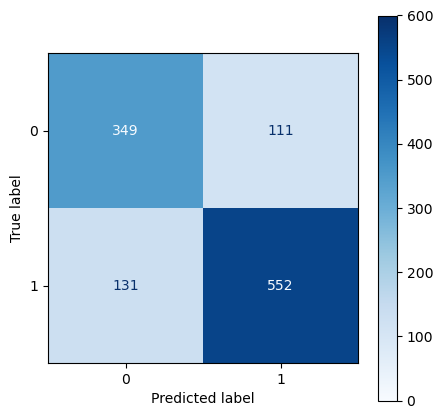

In [139]:
# confusion matrix figure
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df_predictions['y_test'], df_predictions['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap='Blues');

# decrease figure size
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(5, 5)
disp.ax_.get_images()[0].set_clim(0, 600)

In [164]:
## same code but for single trace

# sample random trace
running_trace = all_traces.sample(1)
historic_traces = all_traces.drop(running_trace.index)

# TODO: prefix extraction of historic traces?

# calculate similarity scores
similarity_scores = get_similarity(running_trace, historic_traces, similarity=True)

# get n most similar traces
n = 100
sorted_similar_traces = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
most_similar_traces = sorted_similar_traces[:n]

# calculate average similarity score
avg_similarity = np.mean([x[1] for x in most_similar_traces])
print_label = 'Average similarity score' ; print(f'{print_label:<25}: {avg_similarity:.3f}')

# get label function
similar_traces_list = [x[0] for x in most_similar_traces]
lf_map = get_lf_map(event_log, label_function_1)

# get y_train and y_test
y_train = [lf_map[trace] for trace in similar_traces_list]
print_label = 'Traces in class 1' ; print(f'{print_label:<25}: {sum(y_train)}/{len(y_train)}')
y_test = int(lf_map[running_trace.index[0]])
print_label = 'True class running trace' ; print(f'{print_label:<25}: {y_test}')

# train model
X_cols = ['case:Diagnosis code', 'case:Treatment code']
clf, le_dict = train_model(X_cols, event_log, similar_traces_list, lf_map)

# predict label
y_pred = predict_label(X_cols, event_log, running_trace, clf, le_dict)
print_label = 'Pred class running trace' ; print(f'{print_label:<25}: {y_pred}')


Average similarity score : 0.327
Traces in class 1        : 25/100
True class running trace : 0
Pred class running trace : 0


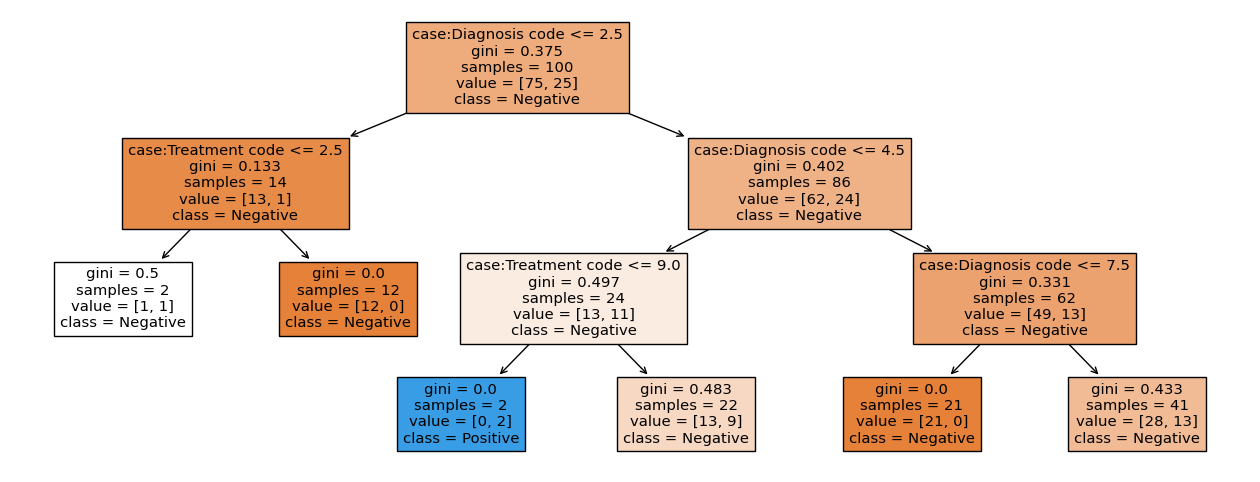

In [166]:
# check decision tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plot_tree(clf, feature_names=X_cols, filled=True, class_names=['Negative', 'Positive']);

In [12]:
# percentages of non-missing values for each X column
X_cols = ['case:Diagnosis code', 'case:Treatment code']
for col in X_cols:
    print(col)
    x = event_log.groupby('case:concept:name')[col].last().notna().sum() / event_log['case:concept:name'].nunique()
    print(x)

case:Diagnosis code
0.6019247594050744
case:Treatment code
0.5914260717410323


### Visualizations

In [ ]:
def get_similar_traces(running_trace, traces, threshold=40):
    
    # convert running trace to list if it is a series
    if isinstance(running_trace, pd.Series):
        running_trace = running_trace.iloc[0]
    
    # find similar traces
    similar_traces = []
    for case, activities in traces.items():
        distance = editdistance.eval(running_trace, activities)
        if distance <= threshold:
            similar_traces.append((case, distance))
    return dict(similar_traces)

In [123]:
df_list = []
for th in range(0, 205, 10):
    n_similar_traces = []
    for _ in range(50):
        running_trace = all_traces.sample(1)
        historic_traces = all_traces.drop(running_trace.index)
        similar_traces = get_similar_traces(running_trace, historic_traces, threshold=th)
        n_similar_traces.append(len(similar_traces))
    mean_similar_traces = sum(n_similar_traces) / len(n_similar_traces)
    min_similar_traces = min(n_similar_traces)
    df_list.append([th, mean_similar_traces, min_similar_traces])

df_th = pd.DataFrame(df_list, columns=['Threshold', 'Mean similar traces', 'Min similar traces'])

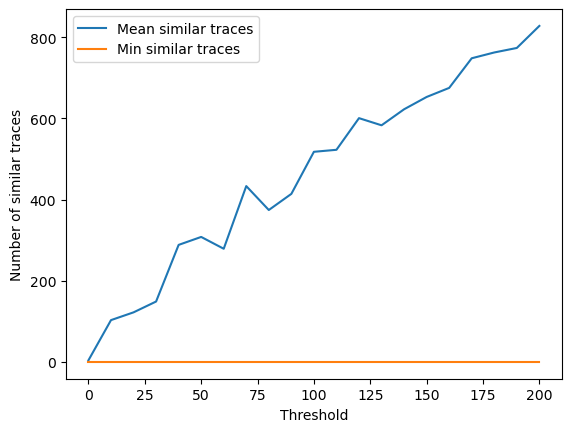

In [124]:
# plot threshold and number of similar traces
import matplotlib.pyplot as plt

plt.plot(df_th['Threshold'], df_th['Mean similar traces'], label='Mean similar traces')
plt.plot(df_th['Threshold'], df_th['Min similar traces'], label='Min similar traces')
plt.xlabel('Threshold')
plt.ylabel('Number of similar traces')
plt.legend();